## Table of Contents

#### Exploratory Data Analysis

1. Characterization & Cleaning <a href=></a>
    * Features
    * Primary Types
2. 


#### ML?

In [38]:
import pyspark
import warnings
import matplotlib
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession

matplotlib.rcParams['figure.dpi'] = 300

!sed -i 's/hadoop.root.logger=INFO,console/hadoop.root.logger=WARN,console/' /usr/hadoop-3.3.2/etc/hadoop/log4j.properties
warnings.filterwarnings('ignore')

In [2]:
conf = pyspark.SparkConf().setAll(
    [('spark.master', 'local[2]'),
     ('spark.app.name', 'EDA')])
spark = SparkSession.builder.config(conf=conf).getOrCreate()

2023-05-06 00:17:18,209 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2023-05-06 00:17:19,278 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [11]:
df = spark.read.csv('file:///home/work/Project/mas-dse-230/crime.csv', header=True)
df = df.filter("Year < 2023")
# Ignore 2023 to only look at completed years

#### Features

In [9]:
' *--* '.join([i.name for i in df.schema])

'ID *--* Case Number *--* Date *--* Block *--* IUCR *--* Primary Type *--* Description *--* Location Description *--* Arrest *--* Domestic *--* Beat *--* District *--* Ward *--* Community Area *--* FBI Code *--* X Coordinate *--* Y Coordinate *--* Year *--* Updated On *--* Latitude *--* Longitude *--* Location'

### Feature: Primary Type

In [15]:
ptypes = df.select('Primary Type').distinct().orderBy('Primary Type')
ptypes.show(100, truncate=False)

+---------------------------------+
|Primary Type                     |
+---------------------------------+
|ARSON                            |
|ASSAULT                          |
|BATTERY                          |
|BURGLARY                         |
|CONCEALED CARRY LICENSE VIOLATION|
|CRIM SEXUAL ASSAULT              |
|CRIMINAL DAMAGE                  |
|CRIMINAL SEXUAL ASSAULT          |
|CRIMINAL TRESPASS                |
|DECEPTIVE PRACTICE               |
|DOMESTIC VIOLENCE                |
|GAMBLING                         |
|HOMICIDE                         |
|HUMAN TRAFFICKING                |
|INTERFERENCE WITH PUBLIC OFFICER |
|INTIMIDATION                     |
|KIDNAPPING                       |
|LIQUOR LAW VIOLATION             |
|MOTOR VEHICLE THEFT              |
|NARCOTICS                        |
|NON - CRIMINAL                   |
|NON-CRIMINAL                     |
|NON-CRIMINAL (SUBJECT SPECIFIED) |
|OBSCENITY                        |
|OFFENSE INVOLVING CHILDREN 

A few labels appear to be variations of the same `Primary Type`.

> For example:
> 
> `NON-CRIMINAL` and `NON - CRIMINAL`

These variations will be consolidated to simplify analysis.

In [20]:
consolidation = {
    'CRIM SEXUAL ASSAULT': 'CRIMINAL SEXUAL ASSAULT',
    'NON-CRIMINAL (SUBJECT SPECIFIED)': 'NON-CRIMINAL',
    'NON - CRIMINAL': 'NON-CRIMINAL',
    'OTHER NARCOTIC VIOLATION': 'NARCOTICS',
    'PUBLIC INDECENCY': 'PUBLIC INDECENCY/OBSCENITY',
    'OBSCENITY': 'PUBLIC INDECENCY/OBSCENITY'
}

for k, v in consolidation.items():
    df = df.replace(k, v, 'Primary Type')

In [40]:
pie

[Row(Primary Type='DOMESTIC VIOLENCE', count=1),
 Row(Primary Type='RITUALISM', count=24),
 Row(Primary Type='HUMAN TRAFFICKING', count=98),
 Row(Primary Type='NON-CRIMINAL', count=228),
 Row(Primary Type='PUBLIC INDECENCY/OBSCENITY', count=1000),
 Row(Primary Type='CONCEALED CARRY LICENSE VIOLATION', count=1019),
 Row(Primary Type='INTIMIDATION', count=4591),
 Row(Primary Type='STALKING', count=4653),
 Row(Primary Type='KIDNAPPING', count=7184),
 Row(Primary Type='HOMICIDE', count=12391),
 Row(Primary Type='ARSON', count=13122),
 Row(Primary Type='GAMBLING', count=14616),
 Row(Primary Type='LIQUOR LAW VIOLATION', count=14846),
 Row(Primary Type='INTERFERENCE WITH PUBLIC OFFICER', count=18204),
 Row(Primary Type='SEX OFFENSE', count=30314),
 Row(Primary Type='CRIMINAL SEXUAL ASSAULT', count=33892),
 Row(Primary Type='PUBLIC PEACE VIOLATION', count=52083),
 Row(Primary Type='OFFENSE INVOLVING CHILDREN', count=55109),
 Row(Primary Type='PROSTITUTION', count=69750),
 Row(Primary Type='WEA

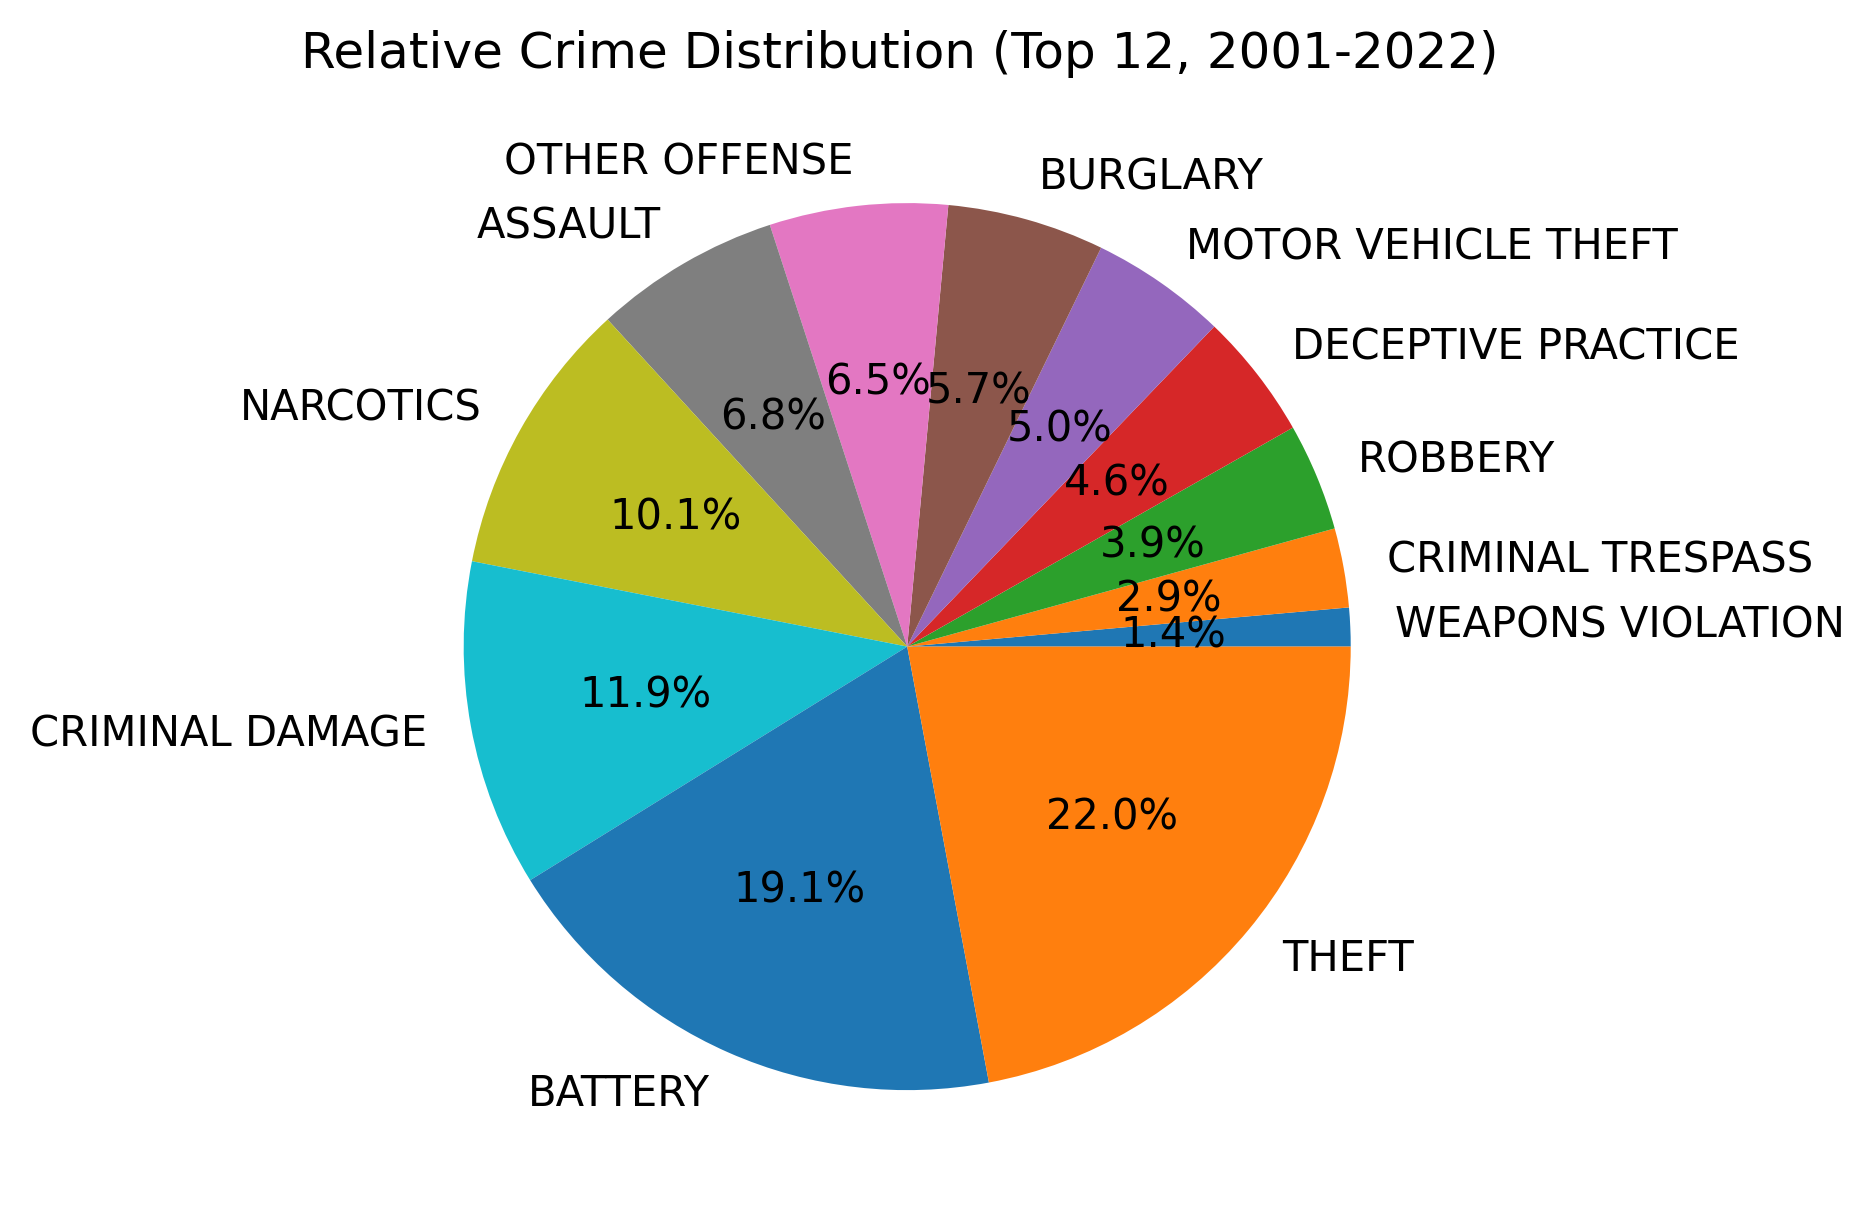

In [54]:
pie = df.groupBy('Primary Type').count().where('count > 100000').orderBy('count').collect()

# `where` to remove the less common categories (overwhelming pie)

fig, ax = plt.subplots()
ax.pie(
    [pt[1] for pt in pie],
    labels=[pt[0] for pt in pie],
    autopct='%1.1f%%',
)
plt.title('Relative Crime Distribution (Top 12, 2001-2022) ')
fig.show()

### Maps

In [23]:
query = '''
SELECT CAST(`Ward` AS INT) AS ward
    , COUNT(*) AS n_crimes
FROM crime
WHERE `Ward` IS NOT NULL
GROUP BY `Ward`
'''
df = spark.sql(query).toPandas().to_csv('map_ward.csv', index=False)

In [25]:
query = '''
WITH cte (
    SELECT `Ward`
        , SUM(CASE Arrest
            WHEN 'false' THEN 0
            WHEN 'true' THEN 1 END) AS count_true
        , COUNT(`Arrest`) AS total
    FROM crime
    WHERE Year < 2023
    GROUP BY `Ward`
)
SELECT *
    , count_true/total AS proportion_arrested
FROM cte
'''
tdf = spark.sql(query).toPandas().to_csv('map_arrest_rate.csv',index=False)

In [9]:
query = '''
WITH cte (
    SELECT `Primary Type`
        , SUM(CASE Arrest
            WHEN 'false' THEN 0
            WHEN 'true' THEN 1 END) AS count_true
        , COUNT(`Arrest`) AS total
    FROM crime
    WHERE Year < 2023
    GROUP BY `Primary Type`
)
SELECT *
    , count_true/total AS proportion_arrested
FROM cte
'''
tdf = spark.sql(query).toPandas().to_csv('arrest_rates.csc', index=False)